# add some tips

https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9



In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import time 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

os.environ["CUDA_VISIBLE_DEVICES"]="0"

def my_mnist_train_batch(size) :
    m = 500
    data = []
    for i in range(1000) :
        number = number = np.random.randint(5)
        image, label = mnist.train.next_batch(m)       
        for j in range(len(label)) : 
            
            if np.argmax(label[j])==number :
                data.append(image[j])
                number = number = np.random.randint(5)
            if len(data) == size :
                break
        if len(data) == size :
            break
    return data

def my_mnist_test_batch(size, number = 0) :
    m = 500
    data = []
    for i in range(1000) :
        image, label = mnist.test.next_batch(m)       
        for j in range(len(label)) : 
            if np.argmax(label[j])==number :
                data.append(image[j])              
            if len(data) == size :
                break
        if len(data) == size :
            break
    return data

def mnist_4by4_save(samples,path):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)    
    gs.update(wspace=0.05, hspace=0.05) #이미지 사이간격 조절
  
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
   
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r',clim=(0.0,1.0))
    plt.colorbar()
    plt.savefig(path, bbox_inches='tight')
    plt.close(fig)
   
    return None

def gan_loss_graph_save(G_loss,D_loss,path):
    x1 = range(len(G_loss))
    x2 = range(len(D_loss))
      
    y1 = G_loss
    y2 = D_loss
  
      
    plt.plot(x1,y1,label='G_loss') 
    plt.plot(x2,y2,label='D_loss') 
  
    plt.xlabel('weight per update')
    plt.ylabel('loss')             
    plt.legend(loc=4)              
    plt.grid(True)
    plt.tight_layout()
  
    plt.savefig(path)              

    return None


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data", one_hot=True)

file_name = 'ex_anoGANs_4_case1'

if not os.path.isdir(file_name) :
    os.mkdir(file_name)
def simple_G(x,isTrain = True, reuse = False, name = 'G_out') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)


    with tf.variable_scope('G',reuse=reuse)  :
        
        #x = (-1, 1, 1, 100)

        conv1 = tf.layers.conv2d_transpose(x,2048,[4,4], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#1024*4*4
        
        conv2 = tf.layers.conv2d_transpose(r1,1024,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#512*8*8
                
        conv3 = tf.layers.conv2d_transpose(r2,512,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

        conv4 = tf.layers.conv2d_transpose(r3,256,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#128*32*32

        conv5 = tf.layers.conv2d(r4,128,[3,3], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init)
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#64*30*30

        conv6 = tf.layers.conv2d(r5,1,[3,3], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init)
    r6 = tf.nn.tanh(conv6,name=name)#1*28*28
  

    return r6
def residual_loss_G(x,isTrain = False, reuse = True, name = 'residual_loss_out') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    


    with tf.variable_scope('G',reuse=reuse) as scope :
        scope.reuse_variables()
        #x = (-1, 1, 1, 100)


        conv1 = tf.layers.conv2d_transpose(x,2048,[4,4], strides=(1,1),padding = 'valid')
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#1024*4*4
        
        conv2 = tf.layers.conv2d_transpose(r1,1024,[4,4], strides=(2,2),padding = 'same')
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#512*8*8
                
        conv3 = tf.layers.conv2d_transpose(r2,512,[4,4], strides=(2,2),padding = 'same')
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

        conv4 = tf.layers.conv2d_transpose(r3,256,[4,4], strides=(2,2),padding = 'same')
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#128*32*32

        conv5 = tf.layers.conv2d(r4,128,[3,3], strides=(1,1),padding = 'valid')
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#64*30*30

        conv6 = tf.layers.conv2d(r5,1,[3,3], strides=(1,1),padding = 'valid')
    r6 = tf.nn.tanh(conv6,name=name)#1*28*28
  

    return r6
def simple_D(x,isTrain=True,reuse = False) :
    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)
    with tf.variable_scope('D', reuse=reuse) :
        
        #x = (-1,28,28,1)
        # out size = (in size + 2*padding - kenel)/strides + 1   

        conv1 = tf.layers.conv2d(x,128,[5,5], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(conv1)#64*24*24

   
        conv2 = tf.layers.conv2d(r1,256,[5,5], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#128*20*20

  
        conv3 = tf.layers.conv2d(r2,512,[5,5], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

 
        conv4 = tf.layers.conv2d(r3,1024,[4,4], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#512*8*8


        conv5 = tf.layers.conv2d(r4,2048,[4,4], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#1024*4*4

       
        conv6 = tf.layers.conv2d(r5,1,[4,4], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init)
    r6 = tf.nn.sigmoid(conv6)#1*1*1


    return r6
def feature_extractor_D(x,isTrain=False,reuse = True, name='feature_out') :
    
    with tf.variable_scope('D', reuse=reuse) as scope :
        scope.reuse_variables()
        #x = (-1,28,28,1)

        conv1 = tf.layers.conv2d(x,128,[5,5], strides=(1,1),padding = 'valid')
        r1 = tf.nn.elu(conv1)#64*24*24

   
        conv2 = tf.layers.conv2d(r1,256,[5,5], strides=(1,1),padding = 'valid')
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#128*20*20

  
        conv3 = tf.layers.conv2d(r2,512,[5,5], strides=(1,1),padding = 'valid')
    r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain),name = name)#256*16*16

 
        #conv4 = tf.layers.conv2d(r3,1024,[4,4], strides=(2,2),padding = 'same')
        #r4 = tf.nn.lrelu(tf.layers.batch_normalization(conv4,training=isTrain),0.2)#512*8*8


        #conv5 = tf.layers.conv2d(r4,2048,[4,4], strides=(2,2),padding = 'same')
        #r5 = tf.nn.lrelu(tf.layers.batch_normalization(conv5,training=isTrain),0.2)#1024*4*4


    return r3



Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
lr = 0.001

z_size = 100


z = tf.placeholder(tf.float32,shape=(None,1,1,z_size),name = 'z')    
u = tf.placeholder(tf.float32, shape = (None, 28,28,1),name='u')

noise = tf.placeholder(tf.float32, shape = (None, 28,28,1),name='noise')

test_u = tf.placeholder(tf.float32, shape = (None, 28,28,1),name='test_u')
latent_z = tf.placeholder(tf.float32,shape=(None,1,1,z_size),name = 'latent_z')    

isTrain = tf.placeholder(dtype=tf.bool,name='isTrain') 

soft_one = tf.placeholder(tf.float32, shape = (None, 1,1,1),name='soft_one') # 0.9~1.0
soft_zero = tf.placeholder(tf.float32, shape = (None, 1,1,1),name='soft_zero') # 0.0~0.1

ramda = tf.placeholder(tf.float32,name='ramda') # 0.0~0.1

G_z = simple_G(z,name='G_z')

D_real = simple_D(u +noise, isTrain)
D_fake = simple_D(G_z+noise ,isTrain,reuse=True)

query_z =  residual_loss_G(latent_z, reuse = True,name ='query_z')


discrimination_from_query_z= simple_D(query_z,isTrain=False,reuse=True)

feature_u = feature_extractor_D(test_u, reuse = True, name ='feature_y')
feature_z = feature_extractor_D(query_z, reuse = True, name ='feature_z')


D_real_loss = tf.reduce_mean(-(soft_one*tf.log(D_real + 1e-8) + (1-soft_one)*tf.log(1- D_real + 1e-8)),name = 'D_real_loss')
D_fake_loss = tf.reduce_mean(-(soft_zero*tf.log(D_fake + 1e-8) + (1-soft_zero)*tf.log(1 - D_fake + 1e-8)),name = 'D_fake_loss')


D_loss =  tf.add(D_real_loss,D_fake_loss,name='D_loss')
G_loss =  tf.reduce_mean(-tf.log(D_fake + 1e-8),name='G_loss')

residual_loss = tf.reduce_mean(tf.abs(query_z - test_u),axis = (1,2,3), name = 'residual_loss')
feature_loss = tf.reduce_mean(tf.abs(feature_u-feature_z),axis = (1,2,3),name = 'feature_loss')
discrimination_loss = tf.reduce_mean(-tf.log(discrimination_from_query_z+ 1e-8),name = 'discrimination_loss')


mapping_loss = tf.add((1-ramda)*residual_loss, ramda*feature_loss,name = 'mapping_loss') 

T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('D')]
G_vars = [var for var in T_vars if var.name.startswith('G')]
    # When using the batchnormalization layers,
    # it is necessary to manually add the update operations
    # because the moving averages are not included in the graph

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)) :        
    D_optim = tf.train.AdamOptimizer(0.001,beta1=0.5).minimize(D_loss, var_list=D_vars, name='D_optim') 
    G_optim = tf.train.AdamOptimizer(0.001,beta1=0.5).minimize(G_loss, var_list=G_vars, name='G_optim')
    
grad_z = tf.gradients(mapping_loss, latent_z, name ='grad_z')
print(grad_z)

In [ ]:
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))) as sess :
    sess.run(tf.global_variables_initializer())

    np.random.seed(int(time.time()))

    test_z = np.random.normal(0,1,size=(16,1,1,z_size))

    
    log_txt = open(file_name +'/log.txt','w')

    hist_G = []
    hist_D = []
    G_error = []
    D_error = []
    D_fake_error = []
    D_real_error = []
    
    start = time.time()
    for i in range(50000) :
        
        train_images = my_mnist_train_batch(100) 
        u_ = np.reshape(train_images,(-1,28,28,1))-0.5 
        z_ = np.random.normal(0,1,size=(100,1,1,z_size))
        noise_ = np.random.normal(0,0.1,size=(100,28,28,1))
        zeros_ = np.zeros([100,28,28,1])
        soft_one_ = np.random.uniform(0.9,1.0,(100,1,1,1))
        soft_zero_ = np.random.uniform(0.0,0.1,(100,1,1,1))
        
        _ , D_e,D_real_e,D_fake_e = sess.run([D_optim, D_loss,D_real_loss,D_fake_loss], {u : u_, z : z_, isTrain : True,
                                                                                         noise : noise_, soft_one : soft_one_, soft_zero : soft_zero_})
        D_error.append(D_e)
        D_real_error.append(D_real_e)
        D_fake_error.append(D_fake_e)


    #    train_images,train_labels = mnist.train.next_batch(100)    
    #    u_ = np.reshape(train_images,(-1,28,28,1)) 
    #    z_ = np.random.normal(0,1,size=(100,1,1,100))
   
        _ , G_e = sess.run([G_optim, G_loss], {u : u_, z : z_,noise : zeros_, isTrain : True}) 
        G_error.append(G_e)
        
        if i%100 == 0:

            hist_D.append(np.mean(D_error)) 
            hist_G.append(np.mean(G_error))

            print('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f'%(np.mean(D_error), np.mean(D_real_error),
                np.mean(D_fake_error), np.mean(G_error)))
            log_txt.write('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f\n'%(np.mean(D_error),
                np.mean(D_real_error), np.mean(D_fake_error), np.mean(G_error)))
      
            r = sess.run([G_z],feed_dict={z : test_z, isTrain : False})        
            mnist_4by4_save(np.reshape(r,(-1,28,28,1)),file_name + '/result_{}.png'.format(str(i).zfill(3)))

            np.random.seed(int(time.time()))

            G_errer = []
            D_errer = []
            D_fake_error = []
            D_real_error = []


    log_txt.close()
    gan_loss_graph_save(G_loss = hist_G,D_loss=hist_D,path = file_name + '/loss_graph.png')   
    saver = tf.train.Saver()
    saver.save(sess,file_name + '/para.cktp')

    end = time.time()-start

    print("total time : ",end)

In [3]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

noise = sess.graph.get_tensor_by_name("noise:0")

test_u = sess.graph.get_tensor_by_name("test_u:0")
latent_z = sess.graph.get_tensor_by_name("latent_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

soft_one =sess.graph.get_tensor_by_name("soft_one:0") # 0.9~1.0
soft_zero = sess.graph.get_tensor_by_name("soft_zero:0") # 0.0~0.1

ramda = sess.graph.get_tensor_by_name("ramda:0")

G_z = sess.graph.get_tensor_by_name("G_z:0")
query_z = sess.graph.get_tensor_by_name("query_z:0")


feature_u = sess.graph.get_tensor_by_name('feature_y:0')
feature_z = sess.graph.get_tensor_by_name('feature_z:0')

D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")

residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
discrimination_loss = sess.graph.get_tensor_by_name("discrimination_loss:0")
mapping_loss = sess.graph.get_tensor_by_name("mapping_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

grad_z =  sess.graph.get_tensor_by_name("grad_z/G_1/conv2d_transpose/conv2d_transpose_grad/Conv2D:0")




INFO:tensorflow:Restoring parameters from ex_anoGANs_4_case1/para.cktp


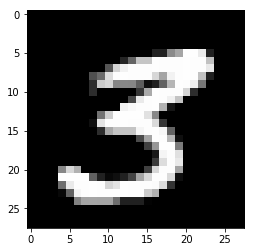

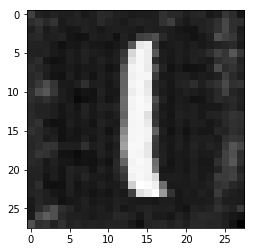

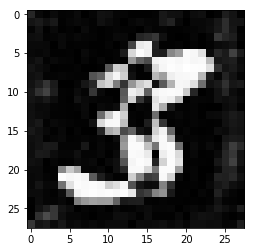

[ 12.75991058] [ 25.32678604] [ 0.1930355]
[ 12.75991058] [ 25.32678604] [ 0.1930355]
[ 12.40736294] [ 24.62508202] [ 0.18964462]
[ 12.39189625] [ 24.59464455] [ 0.18914863]
[ 12.37679386] [ 24.56533432] [ 0.18825355]
[ 12.35940838] [ 24.5317421] [ 0.18707447]
[ 12.33970165] [ 24.49381828] [ 0.1855859]
[ 12.30459404] [ 24.4258194] [ 0.18336925]
[ 12.23209095] [ 24.28298569] [ 0.18119685]
[ 12.11783981] [ 24.05854225] [ 0.17713808]
[ 11.98660183] [ 23.79779434] [ 0.17540972]
[ 11.89440632] [ 23.61615753] [ 0.17265598]
[ 11.86017323] [ 23.54936981] [ 0.17097671]
[ 11.83433723] [ 23.49870872] [ 0.16996528]
[ 11.8166275] [ 23.46427917] [ 0.16897492]
[ 11.79403782] [ 23.41960335] [ 0.16847165]
[ 11.7725563] [ 23.37744522] [ 0.16766775]
[ 11.73678017] [ 23.30715752] [ 0.16640212]
[ 11.53800678] [ 22.91431427] [ 0.16169854]
[ 11.39680672] [ 22.63380432] [ 0.1598091]
[ 11.3021841] [ 22.44569588] [ 0.15867229]
[ 11.23214817] [ 22.30640793] [ 0.15788783]
[ 11.18393993] [ 22.21063232] [ 0.1572481

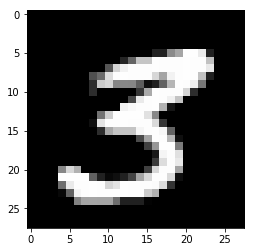

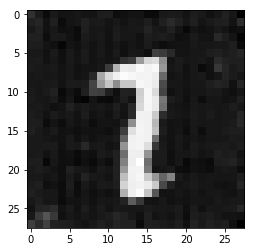

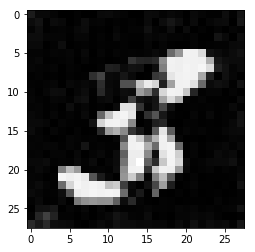

[ 10.96700001] [ 21.77930069] [ 0.1547002]


In [4]:
####
test_batch = 1
ramda_ = 0.5
z_size = 100

np.random.seed(10)


#latent_z_ = np.random.normal(0,1,size=(test_batch,1,1,z_size))
latent_z_ = np.random.uniform(-1.0,1.0,(test_batch,1,1,z_size))
####


im = np.array(my_mnist_test_batch(test_batch, number = 3)) -0.5
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([query_z],{latent_z : latent_z_}) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  


############################################


#latent_z_ = np.random.normal(0,1,size=(test_batch,1,1,z_size))
map_loss, fea_loss, res_loss = sess.run([mapping_loss, feature_loss,residual_loss], 
                                        {test_u : np.reshape(im,(1,28, 28,1)), latent_z : latent_z_, ramda : ramda_ })
adam_m = np.zeros((test_batch,1,1,z_size))
adam_v = np.zeros((test_batch,1,1,z_size))
beta1 = 0.1
beta2 = 0.999
lr = 0.001
beta1_t = beta1
beta2_t = beta2

print(map_loss, fea_loss, res_loss)

for i in range(5000) :
     
    grad,map_loss, fea_loss, res_loss = sess.run([grad_z,mapping_loss, feature_loss,residual_loss],
                                                 {test_u : np.reshape(im,(-1,28, 28,1)), latent_z : latent_z_, ramda : ramda_ })
    
    lr_t = lr*np.sqrt(1-beta2_t)/(1-beta1_t)
    adam_m = beta1*adam_m + (1-beta1)*grad
    adam_v = beta2*adam_v + (1-beta2)*grad*grad
    latent_z_ = latent_z_ - lr*adam_m/(np.sqrt(adam_v)+1e-8)
    beta1_t = beta1_t*beta1
    beta2_t = beta2_t*beta2
    
    if  i % 100 == 0 : 
        print(map_loss, fea_loss, res_loss)
        
###########################################        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([query_z],{latent_z : latent_z_}) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

map_loss, fea_loss, res_loss = sess.run([mapping_loss, feature_loss,residual_loss], 
                                        {test_u : np.reshape(im,(-1,28, 28,1)), latent_z : latent_z_, ramda : ramda_ })


print(map_loss, fea_loss, res_loss)

0 : [ 1.26591396] [ 12.19823456] [ 0.05121164]

1 : [ 0.40030429] [ 3.88526249] [ 0.01308668]

2 : [ 0.71741045] [ 6.90383625] [ 0.03002984]

3 : [ 0.67283332] [ 6.48380566] [ 0.02716969]

4 : [ 0.58003438] [ 5.63718367] [ 0.01812886]

5 : 0.3318850, 2.439910, 0.0976591

6 : 0.2591080, 2.049630, 0.0601610

7 : 0.4255990, 3.156960, 0.122114

8 : 0.1010440, 0.703177, 0.0341403

9 : 0.0975575, 0.704314, 0.0301401

In [ ]:
####
test_batch = 3
latent_z_ = np.random.normal(0,1,size=(test_batch,1,1,z_size))
####

im = my_mnist_test_batch(test_batch, number = 5) 


############################################

ramda_ = 1.0
z_size = 100
#latent_z_ = np.random.normal(0,1,size=(test_batch,1,1,z_size))
map_loss, fea_loss, res_loss = sess.run([mapping_loss, feature_loss,residual_loss], 
                                        {test_u : np.reshape(im,(-1,28, 28,1)), latent_z : latent_z_, ramda : ramda_ })
adam_m = np.zeros((test_batch,1,1,z_size))
adam_v = np.zeros((test_batch,1,1,z_size))
beta1 = 0.5
beta2 = 0.999
lr = 0.001
beta1_t = beta1
beta2_t = beta2

print(map_loss, fea_loss, res_loss)

for i in range(1000) :
     
    grad,map_loss, fea_loss, res_loss = sess.run([grad_z,mapping_loss, feature_loss,residual_loss],
                                                 {test_u : np.reshape(im,(-1,28, 28,1)), latent_z : latent_z_, ramda : ramda_ })
    
    lr_t = lr*np.sqrt(1-beta2_t)/(1-beta1_t)
    adam_m = beta1*adam_m + (1-beta1)*grad
    adam_v = beta2*adam_v + (1-beta2)*grad*grad
    latent_z_ = latent_z_ - lr*adam_m/(np.sqrt(adam_v)+1e-8)
    beta1_t = beta1_t*beta1
    beta2_t = beta2_t*beta2
    
    if  i % 100 == 0 : 
        print(map_loss, fea_loss, res_loss)
        
###########################################        

    

map_loss, fea_loss, res_loss = sess.run([mapping_loss, feature_loss,residual_loss], 
                                        {test_u : np.reshape(im,(-1,28, 28,1)), latent_z : latent_z_, ramda : ramda_ })

print('ddd')
print(map_loss, fea_loss, res_loss)

In [ ]:
grad.shape

In [ ]:
map_loss

In [ ]:
plt.imshow(np.reshape(im[2],(28,28)), cmap='Greys_r')
plt.show()  

In [ ]:
im_fake = sess.run([query_z],{latent_z : latent_z_[2].reshape(1,1,1,100)}) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

In [ ]:
latent_z_[0].reshape(1,1,1,100).shape